In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

# Classification
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#import xgboost as xgb

## Load data 
and save them in a DataFrame

In [2]:
df = pd.read_csv("./data/out_O2.csv")
T, nb_sim = np.shape(df)
nb_sim -= 1
print("Time horizon:", T)
print("Number of simulations:", nb_sim)

Time horizon: 36
Number of simulations: 100


In [3]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100
0,4,0.005052,0.003791,0.004347,0.005034,0.003972,0.003885,0.004903,0.005147,0.003603,...,0.003783,0.003848,0.005055,0.003721,0.003654,0.004256,0.004170,0.004998,0.003759,0.004300
1,5,0.005036,0.003788,0.004339,0.005019,0.003968,0.003881,0.004889,0.005129,0.003601,...,0.003780,0.003845,0.005039,0.003718,0.003651,0.004249,0.004164,0.004983,0.003756,0.004292
2,6,0.005042,0.003796,0.004347,0.005025,0.003976,0.003889,0.004895,0.005135,0.003609,...,0.003788,0.003853,0.005045,0.003726,0.003659,0.004257,0.004172,0.004989,0.003764,0.004300
3,7,0.005041,0.003799,0.004349,0.005024,0.003979,0.003893,0.004895,0.005134,0.003613,...,0.003791,0.003856,0.005045,0.003730,0.003663,0.004259,0.004175,0.004989,0.003768,0.004303
4,8,0.005026,0.003795,0.004340,0.005008,0.003973,0.003887,0.004881,0.005117,0.003609,...,0.003787,0.003851,0.005029,0.003726,0.003659,0.004251,0.004167,0.004974,0.003763,0.004294


In [4]:
def plot_data(df):
    variables = [col for col in list(df.columns) if 'V' in col]
    
    plt.figure()
    for col in variables:
        plt.plot(df[col])
    plt.title('O2 evolution on {} simulations'.format(len(variables)))
    plt.ylabel('O2')
    plt.xlabel('time')
    plt.show()

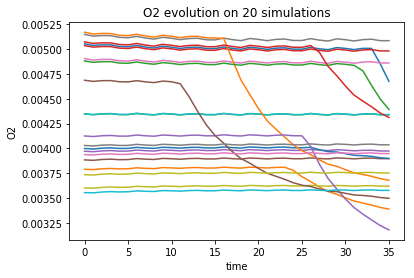

In [5]:
var = ['V' + str(i) for i in range(1, 21)]
plot_data(df[var])

## Set the parameters:
* **len_X**: the len_x last values of X are taken into account to compute descriptors
* **tau**: We want to predict if an accident happens at t + tau

The following variables are used to determine the event: "accident" that we want to predict:
* **thres_mean**: If |mean(X(0), ..., (t-1)) - X(t)| < thres_mean, then there is an accident at t.
* **X0_base, thres_gal**: If |X(t) - X0| < thres_gal then there is an accident.

In [6]:
params = {'len_X': 10,
          'tau': 5,
          'thres_mean': 5e-5,
          'X0_base': 0.0042,
          'thres_gal': 0.001}

variables = [col for col in list(df.columns) if 'V' in col]

### Processing X data and compute the accident variable Y

In [7]:
def process_var(df, variables):
    
    # Concatenation des x
    X = []
    trajec = []
    X_cummean = []

    for j in range(len(variables)):
        col = variables[j]
        X += list(df[col])
        # Trajec = the number of the trajectory
        trajec += [j for _ in range(len(df))]

        # CumMean of X (t-1 previous values)
        cummean = np.cumsum(df[col]) / np.array(range(1, len(df)+1))
        X_cummean += [df[col][0]] + list(cummean[:-1])

    data = pd.DataFrame({'X': X, 'trajec': trajec, 'X_cummean': X_cummean})
    
    # Compute Y
    data['X_diff'] = abs(data['X'] - data['X_cummean'])
    # The difference between X and the cummean is it below the threshold thres_mean ?
    data['Y1'] = data['X_diff'].apply(lambda x: 1 if x > params['thres_mean'] else 0)
    # The value of X is it below the general threshold thres_gal ?
    data['Y2'] = data['X'].apply(lambda x: 1 if abs(x - params['X0_base']) > params['thres_gal'] else 0)

    # The incident happens if one of the two previous event happen
    data['Y'] = data['Y1'] + data['Y2']
    data['Y'] = data['Y'].apply(lambda x: 1 if x > 0 else 0)
    
    return data[['Y', 'X', 'trajec']]

In [8]:
data = process_var(df, variables)

In [9]:
data.head(T + 1)

,Y,X,trajec
0,0,0.005052,0
1,0,0.005036,0
2,0,0.005042,0
3,0,0.005041,0
4,0,0.005026,0
5,0,0.005022,0
6,0,0.005036,0
7,0,0.005020,0
8,0,0.005010,0
9,0,0.005028,0


**trajec** is the number of the trajectory. When the number change, the value correspond to a new person.

## Compute descriptors on X data

In [10]:
# Separate data x in windows of lenght len_X
# and compute descriptors on this window

descriptors = {'X': [], 'Y': [], 'trajec': [],
               'mean': [],
               'diff_to_mean': [],
               'diff_first_second_mean': [],
               'diff_to_X0': []}
for i in range(1, params['len_X'] + 1):
    descriptors['X_{}'.format(i)] = []

nb_trajec = len(np.unique(data['trajec']))

for n in range(nb_trajec):
    for j in range(params['len_X'], T - params['tau']):
        i = n*T + j
        X_ = list(data['X'][i - params['len_X']:i])  # Past
        
        descriptors['X'].append(data['X'][i])
        descriptors['Y'].append(data['Y'][i])
        descriptors['trajec'].append(data['trajec'][i])

        descriptors['mean'].append(np.mean(X_))
        descriptors['diff_to_mean'].append(np.abs(data['X'][i] - np.mean(X_)))
        descriptors['diff_first_second_mean'].append(np.abs(np.mean(X_[:int(params['len_X']/2)])\
                                                            - np.mean(X_[int(params['len_X']/2):])))
        descriptors['diff_to_X0'].append(np.abs(np.mean(X_) - params['X0_base']))
        
        # Past values
        for k in range(1, params['len_X'] + 1):
            descriptors['X_{}'.format(k)].append((data['X'][i - k]))

descriptors = pd.DataFrame(descriptors)

name_descriptors = list(descriptors.columns)
name_descriptors.remove('X')
name_descriptors.remove('Y')
name_descriptors.remove('trajec')
print("The descriptors computed are:", name_descriptors)
print("{} trajectories of length {}".format(nb_trajec, T))

The descriptors computed are: ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']
100 trajectories of length 36


### Correlation coefficients

In [11]:
print("Correlation coefficients between the variables:")
descriptors[['X', 'Y', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']].corr()

Correlation coefficients between the variables:


,X,Y,diff_first_second_mean,diff_to_X0,diff_to_mean,mean
X,1.000000,-0.314274,-0.309389,0.401328,-0.295700,0.978113
Y,-0.314274,1.000000,0.713744,-0.054708,0.848328,-0.141981
diff_first_second_mean,-0.309389,0.713744,1.000000,-0.038874,0.881526,-0.130755
diff_to_X0,0.401328,-0.054708,-0.038874,1.000000,-0.066632,0.403692
diff_to_mean,-0.295700,0.848328,0.881526,-0.066632,1.000000,-0.090716
mean,0.978113,-0.141981,-0.130755,0.403692,-0.090716,1.000000


**Remarques:**
La variable à prédire Y est fortement corrélées avec les deux variables decrivant la différence à la moyenne passée ('diff_to_mean', 'diff_first_second_mean'). Ces deux variables sont aussi corrélées, il vaut mieux choisir l'une des deux.

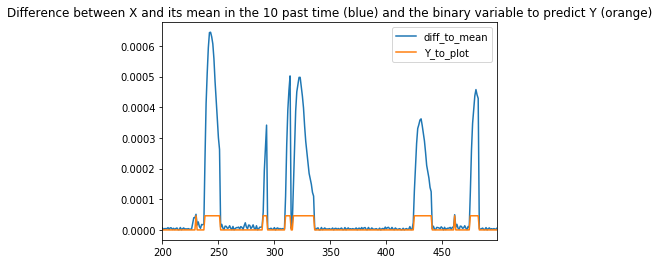

In [12]:
descriptors['Y_to_plot'] = descriptors['Y'] * descriptors['diff_to_mean'].mean()

descriptors[['diff_to_mean', 'Y_to_plot']][200:500].plot()
plt.title('Difference between X and its mean in the {} past time (blue) and \
the binary variable to predict Y (orange)'.format(params['len_X']))
plt.show()

La corrélation est assez marquante entre la variable "différence avec la moyenne passée" et l'apparition d'un accident.

### Plot descriptors

In [13]:
descriptors.keys()

Index(['X', 'X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8',
       'X_9', 'Y', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean',
       'mean', 'trajec', 'Y_to_plot'],
      dtype='object')

In [40]:
# Liste des trajectoires qui degenerent:

trajec_accident = []

for trajec in range(nb_sim):
    if len(np.unique(descriptors[descriptors['trajec'] == trajec]['Y'])) > 1:
        trajec_accident.append(trajec)
        
np.reshape(trajec_accident, (1, len(trajec_accident)))

array([[ 1, 10, 11, 13, 14, 15, 20, 21, 22, 25, 26, 27, 31, 35, 36, 38, 39,
        42, 43, 45, 50, 52, 54, 58, 60, 61, 63, 66, 71, 77, 78, 79, 80, 82,
        86, 87, 88, 89, 90, 91, 93, 95, 96, 97]])

In [53]:
def plot_trajec_diff_to_mean(trajec_data):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    ax1.plot(trajec_data['X'], label='X', color='r')
    ax2.plot(trajec_data['diff_to_mean'], label='diff_to_mean', color='b')
    ax3.plot(trajec_data['Y'], label='Y', color='black')

    ax3.legend()
    ax1.legend()
    ax2.legend()
    plt.title("Evolution of the descriptors of a patient having an accident")
    plt.show()

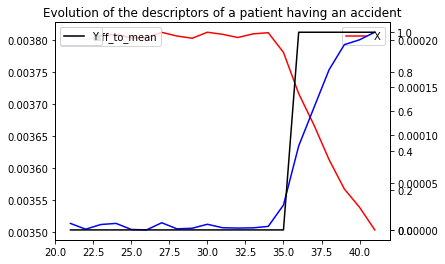

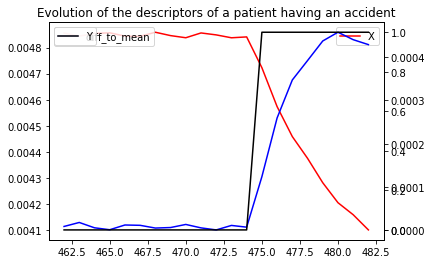

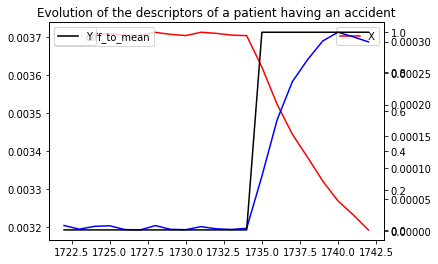

In [55]:
trajec1 = descriptors[descriptors['trajec'] == 1]
plot_trajec_diff_to_mean(trajec1)
plot_trajec_diff_to_mean(descriptors[descriptors['trajec'] == 22])
plot_trajec_diff_to_mean(descriptors[descriptors['trajec'] == 82])

In [49]:
trajec1_Y0 = trajec1[trajec1['Y'] == 0]
trajec1_Y1 = trajec1[trajec1['Y'] == 1]

In [51]:
trajec1_Y1[['diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']]

,diff_first_second_mean,diff_to_X0,diff_to_mean,mean
36,0.000004,0.000395,0.000089,0.003805
37,0.000024,0.000404,0.000129,0.003796
38,0.000050,0.000418,0.000169,0.003782
39,0.000090,0.000437,0.000195,0.003763
40,0.000140,0.000461,0.000200,0.003739
41,0.000182,0.000488,0.000208,0.003712


In [52]:
trajec1_Y0[['diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']]

,diff_first_second_mean,diff_to_X0,diff_to_mean,mean
21,7.841371e-06,0.000402,7.402829e-06,0.003798
22,8.574369e-06,0.000401,1.349353e-06,0.003799
23,3.895011e-06,0.000400,6.266082e-06,0.003800
24,4.183606e-06,0.000399,7.416431e-06,0.003801
25,6.795591e-06,0.000398,1.063706e-06,0.003802
26,3.286922e-06,0.000397,5.886761e-07,0.003803
27,1.267889e-06,0.000396,8.082101e-06,0.003804
28,4.661409e-06,0.000395,1.729430e-06,0.003805
29,3.386891e-06,0.000395,2.323094e-06,0.003805
30,5.159545e-08,0.000394,6.510725e-06,0.003806


### Equilibrer les classes 

Il est important d'équilibrer les classes, i.e. avoir autant de données avec Y=1 et Y=0 pour entrainer un classifieur.

In [112]:
print(np.unique(descriptors['Y']))
len_Y1 = np.sum(descriptors['Y'])
len_Y0 = -np.sum([x - 1 for x in descriptors['Y']])
print("In the original database:")
print("Y=1:", len_Y1, "data")
print("Y=0:", len_Y0, "data")

[0 1]
In the original database:
Y=1: 346 data
Y=0: 1754 data


In [16]:
X1 = descriptors[descriptors['Y'] == 1]
X0 = descriptors[descriptors['Y'] == 0]
indices = np.random.permutation(range(len(X0)))

if len_Y1 < len_Y0:
    new_X0 = X0.iloc[indices[:len_Y1]]
    new_X1 = X1
else:
    new_X0 = X0
    new_X1 = X1.iloc[indices[:len_Y0]]
    
new_X = pd.concat((new_X0, new_X1))

print("In the new database:")
print("Y=1:", np.sum(new_X['Y']), "data")
print("Y=0:", -np.sum([x - 1 for x in new_X['Y']]), "data")

In the new database:
Y=1: 346 data
Y=0: 346 data


In [17]:
new_X.head()

,X,X_1,X_10,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,Y,diff_first_second_mean,diff_to_X0,diff_to_mean,mean,trajec,Y_to_plot
1215,0.004968,0.004977,0.004972,0.004991,0.004973,0.004973,0.004987,0.004983,0.004971,0.004983,0.004992,0,6.867930e-08,0.000780,0.000012,0.004980,57,0.0
1441,0.005098,0.005094,0.005105,0.005081,0.005094,0.005103,0.005082,0.005091,0.005107,0.005089,0.005090,0,5.713101e-06,0.000893,0.000004,0.005093,68,0.0
1335,0.003964,0.003958,0.003962,0.003964,0.003967,0.003957,0.003961,0.003968,0.003958,0.003958,0.003964,0,6.705165e-07,0.000238,0.000003,0.003962,63,0.0
645,0.004972,0.004972,0.004977,0.004986,0.004982,0.004970,0.004982,0.004991,0.004971,0.004980,0.004994,0,3.750312e-06,0.000780,0.000008,0.004980,30,0.0
2005,0.004257,0.004262,0.004257,0.004249,0.004255,0.004263,0.004252,0.004252,0.004260,0.004257,0.004250,0,9.299692e-07,0.000056,0.000002,0.004256,95,0.0


# Classification

#### Choose descriptors

In [18]:
print("Available descriptors:", name_descriptors)

Available descriptors: ['X_1', 'X_10', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'diff_first_second_mean', 'diff_to_X0', 'diff_to_mean', 'mean']


In [78]:
# Choose a list of descriptors:
list_descriptors = ['diff_to_mean', 'X']

#### Separate data in test and train set

In [79]:
X_data = np.array(new_X[list_descriptors])
Y_data = np.array(new_X['Y'])

# Separate train / test
pct_test = 0.1
nb_test = int(pct_test * len(X_data))
print("{} data in the test set and {} in the train set".format(nb_test, len(X_data) - nb_test))
indices = np.random.permutation(range(len(X_data)))

X_test = X_data[indices[:nb_test]]
Y_test = Y_data[indices[:nb_test]]

X_train = X_data[indices[nb_test:]]
Y_train = Y_data[indices[nb_test:]]

69 data in the test set and 623 in the train set


In [102]:
print(np.shape(X_train))

(623, 2)


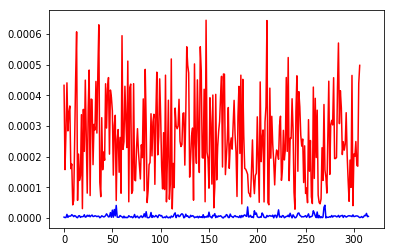

In [89]:
plt.plot(X_Y0[:, 0], color='b')
plt.plot(X_Y1[:, 0], color='r')

plt.show()

In [101]:
Y_predict = X_test[:, 0] > 0.00004
Y_predict = [int(y) for y in Y_predict]

# Score
print("Score {}%".format(round(np.sum(Y_predict == Y_test) / len(Y_test) * 100, 2)))

Score 100.0%


## Test several classifiers

In [108]:
def test_classif_model(model, X_train, Y_train, X_test, Y_test):
    
    model.fit(X_train, Y_train)

    score_train = model.score(X_train, Y_train)
    print("Score on train set: {}%".format(round(score_train*100, 3)))
    score_test = model.score(X_test, Y_test)
    print("Score on test set: {}%".format(round(score_test*100, 3)))

In [110]:
# Classification using a SVM (Support Vector Machine)
print("-- Linear SVM --")
lin_clf = svm.SVC()
test_classif_model(lin_clf, X_train, Y_train, X_test, Y_test)

print("-- Logistic Regression --")
logreg = LogisticRegression()
test_classif_model(logreg, X_train, Y_train, X_test, Y_test)

print("-- Trees --")
TreeClassif = sklearn.tree.DecisionTreeClassifier()
test_classif_model(TreeClassif, X_train, Y_train, X_test, Y_test)

-- Linear SVM --
Score on train set: 50.722%
Score on test set: 43.478%
-- Logistic Regression --
Score on train set: 50.722%
Score on test set: 43.478%
-- Trees --
Score on train set: 100.0%
Score on test set: 100.0%


** Résultats** (sur les données de test)
* Juste **diff_to_mean**: 46%
* 10 données passées: 49%
* **diff_first_second_mean**: 42-44%

In [23]:
# Coefficients de la regression logistique...
logreg.coef_

array([[ 0.03836208, -0.06875177, -0.06875177]])

In [24]:
test = logreg.predict(X_test)

In [25]:
np.unique(test)

array([1], dtype=int64)

In [111]:
import graphviz

ModuleNotFoundError: No module named 'graphviz'

In [144]:
# find threshold

for i in range(1000):
    test = TreeClassif.predict([[(i/100)*10**(-5), 100]])
    if test[0] == 1:
        seuil = (i/100)*10**(-5)
        print("Seuil:", (i/100)*10**(-5))
        break

TreeClassif.predict([[seuil - 1e-7, 100]])[0] , TreeClassif.predict([[seuil, 100]])[0]

Seuil: 2.8e-05


(0, 1)